In [1]:
import sys, pathlib
module_path = pathlib.Path("__file__").resolve().parent
sys.path.insert(0, str(module_path))

### Define the GraphSAGE architecture

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import SAGEConv


class GraphSAGE(nn.Module):
    def __init__(self, 
                 num_features, 
                 num_classes, 
                 dropout_prob, 
                 num_hidden_layers, 
                 hidden_layer_neurons
                ):
        
        super(GraphSAGE, self).__init__()

        # Input layer
        self.conv1 = SAGEConv(num_features, hidden_layer_neurons[0])

        # Hidden layers
        self.hidden_layers = nn.ModuleList()
        for i in range(num_hidden_layers - 1):
            self.hidden_layers.append(SAGEConv(hidden_layer_neurons[i], 
                                               hidden_layer_neurons[i + 1]))

        # Output layer
        self.fc = nn.Linear(hidden_layer_neurons[-1], num_classes)
        self.dropout = nn.Dropout(p=dropout_prob)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        # Input layer
        x = F.relu(self.conv1(x, edge_index))
        x = self.dropout(x)

        # Hidden layers
        for layer in self.hidden_layers:
            x = F.relu(layer(x, edge_index))
            x = self.dropout(x)

        # Output layer
        x = self.fc(x)

        return F.log_softmax(x, dim=1)

### Load the data

In [3]:
from mof_galaxy.main import get_data


# Check if GPU is available and set the device accordingly
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
train_graph, val_graph, test_graph = get_data(device, 
                                              num_val=0.2, 
                                              num_test=0.0, 
                                              alpha=0.9, 
                                              omega=0.9)

### Train the GraphSAGE model and plot the results

Epoch 500/2000 (learning rate: 1.902e-02)
----------------------------------------------------------
Loss [Train, Val]: [1.089, 1.083] 	 Accuracy [Train, Val]: [0.551, 0.558]

Epoch 999/2000 (learning rate: 1.827e-02)
----------------------------------------------------------
Loss [Train, Val]: [1.069, 1.063] 	 Accuracy [Train, Val]: [0.550, 0.554]

Epoch 1498/2000 (learning rate: 1.737e-02)
----------------------------------------------------------
Loss [Train, Val]: [1.064, 1.057] 	 Accuracy [Train, Val]: [0.550, 0.555]

Epoch 1997/2000 (learning rate: 1.652e-02)
----------------------------------------------------------
Loss [Train, Val]: [1.061, 1.052] 	 Accuracy [Train, Val]: [0.555, 0.565]



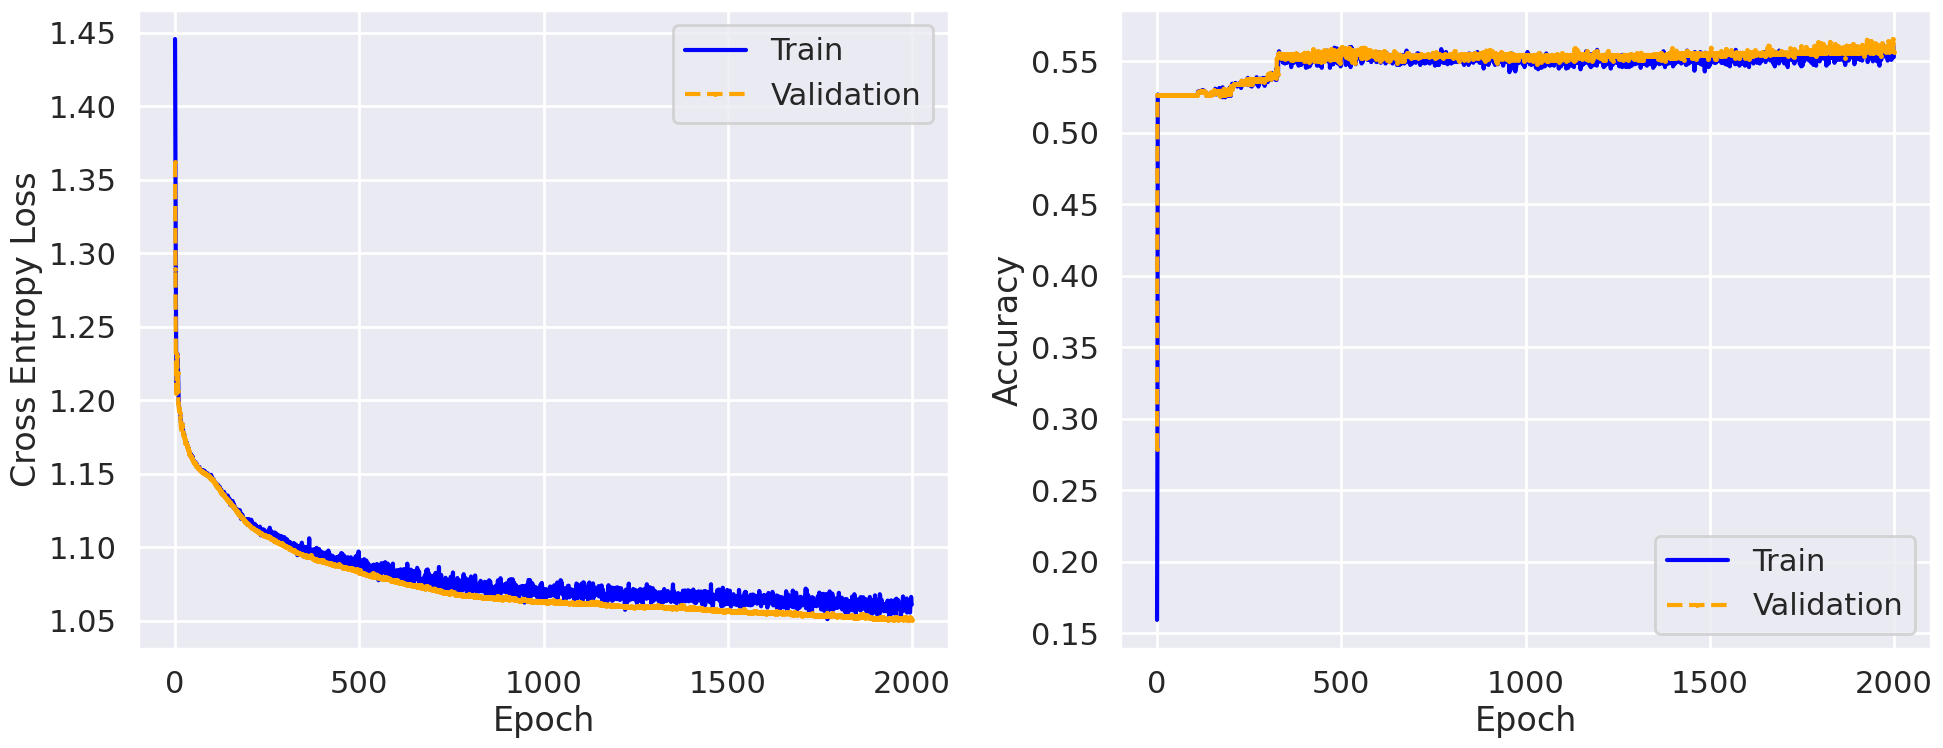

In [4]:
from mof_galaxy.main import train, plot_results
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme("poster")

model = GraphSAGE(num_features=train_graph.x.shape[1], 
                  num_classes=len(train_graph.y.unique()),
                  dropout_prob=0.01,
                  num_hidden_layers=1,
                  hidden_layer_neurons=[32]
                 ).to(device)

trained_model, stats = train(model,
                             train_graph=train_graph,
                             val_graph=val_graph,
                             num_epochs=2000,
                             batch_size=16, 
                             lr=0.02, 
                             lr_step=100, 
                             lr_gamma=0.99, 
                             display_freq=500
                            )

# Plotting
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 8))
axes[0], axes[1] = plot_results(ax_loss=axes[0], ax_acc=axes[1], model_stats=stats)
plt.tight_layout()

### Hyperparameter Tuning with Optuna

#### a) Tuning number of hidden layers, hidden neurons and dropout probability in each layer 

In [5]:
%%time

import optuna

# Define the objective function for Optuna optimization
def objective_layers(trial):
    # Suggest hyperparameters to be optimized
    num_hidden_layers = trial.suggest_int("num_hidden_layers", 1, 3)
    hidden_layer_neurons = []
    possible_neuron_sizes = [16, 32, 64]
    for i in range(num_hidden_layers):
        num_neurons = trial.suggest_categorical(f"neurons_{i+1}", possible_neuron_sizes)
        hidden_layer_neurons.append(num_neurons)
    dropout_prob = lr = trial.suggest_float('dropout_prob', 1e-3, 1e-1, log=True)
    
    # Train the model with suggested hyperparameters
    model = GraphSAGE(num_features=train_graph.x.shape[1], 
                  num_classes=len(train_graph.y.unique()),
                  dropout_prob=dropout_prob,
                  num_hidden_layers=num_hidden_layers,
                  hidden_layer_neurons=hidden_layer_neurons
                 ).to(device)

    trained_model, stats = train(model,
                                 train_graph=train_graph,
                                 val_graph=val_graph,
                                 num_epochs=5000,
                                 batch_size=16, 
                                 lr=0.02, 
                                 lr_step=100, 
                                 lr_gamma=0.99, 
                                 display_freq=5000
                                )

    # Return the validation accuracy as the objective value to be maximized
    return stats['val']['accuracy'][-1]

# Perform Optuna study
study1 = optuna.create_study(direction='maximize')
study1.optimize(objective_layers, n_trials=15)

[I 2023-12-15 19:56:40,009] A new study created in memory with name: no-name-e0cd5223-ca31-4fba-87b3-71154865cee4
[I 2023-12-15 19:57:35,196] Trial 0 finished with value: 0.6790744466800804 and parameters: {'num_hidden_layers': 3, 'neurons_1': 32, 'neurons_2': 64, 'neurons_3': 16, 'dropout_prob': 0.003389654775793487}. Best is trial 0 with value: 0.6790744466800804.


Epoch 5000/5000 (learning rate: 1.210e-02)
----------------------------------------------------------
Loss [Train, Val]: [0.735, 0.748] 	 Accuracy [Train, Val]: [0.684, 0.679]



[I 2023-12-15 19:58:20,757] Trial 1 finished with value: 0.6735412474849095 and parameters: {'num_hidden_layers': 2, 'neurons_1': 64, 'neurons_2': 32, 'dropout_prob': 0.07846275873724493}. Best is trial 0 with value: 0.6790744466800804.


Epoch 5000/5000 (learning rate: 1.210e-02)
----------------------------------------------------------
Loss [Train, Val]: [0.817, 0.776] 	 Accuracy [Train, Val]: [0.645, 0.674]



[I 2023-12-15 19:59:15,821] Trial 2 finished with value: 0.6670020120724346 and parameters: {'num_hidden_layers': 3, 'neurons_1': 32, 'neurons_2': 32, 'neurons_3': 32, 'dropout_prob': 0.0021206598453839087}. Best is trial 0 with value: 0.6790744466800804.


Epoch 5000/5000 (learning rate: 1.210e-02)
----------------------------------------------------------
Loss [Train, Val]: [0.777, 0.764] 	 Accuracy [Train, Val]: [0.663, 0.667]



[I 2023-12-15 20:00:03,508] Trial 3 finished with value: 0.6488933601609658 and parameters: {'num_hidden_layers': 2, 'neurons_1': 64, 'neurons_2': 16, 'dropout_prob': 0.017185671353955573}. Best is trial 0 with value: 0.6790744466800804.


Epoch 5000/5000 (learning rate: 1.210e-02)
----------------------------------------------------------
Loss [Train, Val]: [0.837, 0.815] 	 Accuracy [Train, Val]: [0.639, 0.649]



[I 2023-12-15 20:00:38,567] Trial 4 finished with value: 0.5503018108651911 and parameters: {'num_hidden_layers': 1, 'neurons_1': 16, 'dropout_prob': 0.025507029590957037}. Best is trial 0 with value: 0.6790744466800804.


Epoch 5000/5000 (learning rate: 1.210e-02)
----------------------------------------------------------
Loss [Train, Val]: [1.090, 1.086] 	 Accuracy [Train, Val]: [0.548, 0.550]



[I 2023-12-15 20:01:06,228] Trial 5 finished with value: 0.5618712273641852 and parameters: {'num_hidden_layers': 1, 'neurons_1': 32, 'dropout_prob': 0.059838681926315196}. Best is trial 0 with value: 0.6790744466800804.


Epoch 5000/5000 (learning rate: 1.210e-02)
----------------------------------------------------------
Loss [Train, Val]: [1.067, 1.039] 	 Accuracy [Train, Val]: [0.549, 0.562]



[I 2023-12-15 20:01:39,254] Trial 6 finished with value: 0.6770623742454729 and parameters: {'num_hidden_layers': 2, 'neurons_1': 16, 'neurons_2': 64, 'dropout_prob': 0.009686287580635857}. Best is trial 0 with value: 0.6790744466800804.


Epoch 5000/5000 (learning rate: 1.210e-02)
----------------------------------------------------------
Loss [Train, Val]: [0.808, 0.772] 	 Accuracy [Train, Val]: [0.666, 0.677]



[I 2023-12-15 20:02:05,264] Trial 7 finished with value: 0.5357142857142857 and parameters: {'num_hidden_layers': 1, 'neurons_1': 16, 'dropout_prob': 0.003246484919392904}. Best is trial 0 with value: 0.6790744466800804.


Epoch 5000/5000 (learning rate: 1.210e-02)
----------------------------------------------------------
Loss [Train, Val]: [1.069, 1.066] 	 Accuracy [Train, Val]: [0.530, 0.536]



[I 2023-12-15 20:02:38,357] Trial 8 finished with value: 0.6559356136820925 and parameters: {'num_hidden_layers': 2, 'neurons_1': 64, 'neurons_2': 16, 'dropout_prob': 0.016574969082930997}. Best is trial 0 with value: 0.6790744466800804.


Epoch 5000/5000 (learning rate: 1.210e-02)
----------------------------------------------------------
Loss [Train, Val]: [0.821, 0.781] 	 Accuracy [Train, Val]: [0.640, 0.656]



[I 2023-12-15 20:03:05,344] Trial 9 finished with value: 0.5709255533199196 and parameters: {'num_hidden_layers': 1, 'neurons_1': 32, 'dropout_prob': 0.027734692367621144}. Best is trial 0 with value: 0.6790744466800804.


Epoch 5000/5000 (learning rate: 1.210e-02)
----------------------------------------------------------
Loss [Train, Val]: [1.040, 1.018] 	 Accuracy [Train, Val]: [0.567, 0.571]



[I 2023-12-15 20:03:46,069] Trial 10 finished with value: 0.6775653923541247 and parameters: {'num_hidden_layers': 3, 'neurons_1': 32, 'neurons_2': 64, 'neurons_3': 16, 'dropout_prob': 0.0010177655039776648}. Best is trial 0 with value: 0.6790744466800804.


Epoch 5000/5000 (learning rate: 1.210e-02)
----------------------------------------------------------
Loss [Train, Val]: [0.767, 0.757] 	 Accuracy [Train, Val]: [0.670, 0.678]



[I 2023-12-15 20:04:28,779] Trial 11 finished with value: 0.6866197183098591 and parameters: {'num_hidden_layers': 3, 'neurons_1': 32, 'neurons_2': 64, 'neurons_3': 16, 'dropout_prob': 0.0010089468010801301}. Best is trial 11 with value: 0.6866197183098591.


Epoch 5000/5000 (learning rate: 1.210e-02)
----------------------------------------------------------
Loss [Train, Val]: [0.749, 0.740] 	 Accuracy [Train, Val]: [0.688, 0.687]



[I 2023-12-15 20:05:09,225] Trial 12 finished with value: 0.6861167002012073 and parameters: {'num_hidden_layers': 3, 'neurons_1': 32, 'neurons_2': 64, 'neurons_3': 16, 'dropout_prob': 0.0010508323384063383}. Best is trial 11 with value: 0.6866197183098591.


Epoch 5000/5000 (learning rate: 1.210e-02)
----------------------------------------------------------
Loss [Train, Val]: [0.711, 0.704] 	 Accuracy [Train, Val]: [0.692, 0.686]



[I 2023-12-15 20:05:49,911] Trial 13 finished with value: 0.6976861167002012 and parameters: {'num_hidden_layers': 3, 'neurons_1': 32, 'neurons_2': 64, 'neurons_3': 64, 'dropout_prob': 0.0013487331413721503}. Best is trial 13 with value: 0.6976861167002012.


Epoch 5000/5000 (learning rate: 1.210e-02)
----------------------------------------------------------
Loss [Train, Val]: [0.687, 0.676] 	 Accuracy [Train, Val]: [0.696, 0.698]



[I 2023-12-15 20:06:31,427] Trial 14 finished with value: 0.6921529175050302 and parameters: {'num_hidden_layers': 3, 'neurons_1': 32, 'neurons_2': 64, 'neurons_3': 64, 'dropout_prob': 0.002057307052679193}. Best is trial 13 with value: 0.6976861167002012.


Epoch 5000/5000 (learning rate: 1.210e-02)
----------------------------------------------------------
Loss [Train, Val]: [0.696, 0.691] 	 Accuracy [Train, Val]: [0.688, 0.692]

CPU times: user 8min 43s, sys: 1min 7s, total: 9min 50s
Wall time: 9min 51s


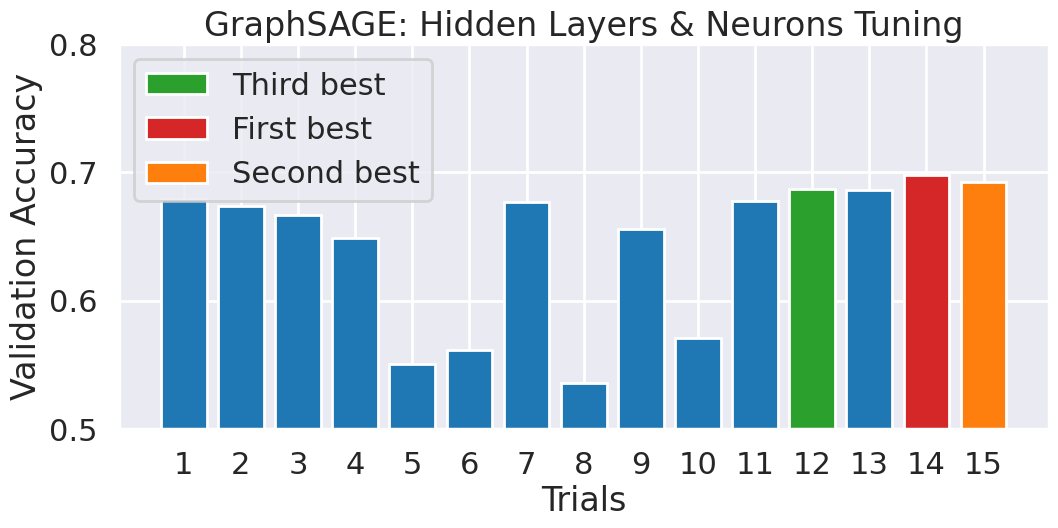

In [8]:
study1_df = study1.trials_dataframe()
study1_df_sort = study1_df.sort_values(by="value", ascending=False).reset_index()
top_three_expts = study1_df_sort["number"].to_numpy()[:3]

fig, ax = plt.subplots(figsize=(12,5))
x_values = [str(i+1) for i in study1_df["number"]]
bar_labels = []
bar_colors = []
for i in range(len(x_values)):
    if i == top_three_expts[0]:
        bar_labels.append("First best")
        bar_colors.append("tab:red")
    elif i == top_three_expts[1]:
        bar_labels.append("Second best")
        bar_colors.append("tab:orange")
    elif i == top_three_expts[2]:
        bar_labels.append("Third best")
        bar_colors.append("tab:green")
    else:
        bar_labels.append("_")
        bar_colors.append("tab:blue")

ax.bar(x_values, study1_df["value"], label=bar_labels, color=bar_colors)
ax.set_xlabel("Trials")
ax.set_ylabel("Validation Accuracy")
ax.set_ylim([0.5, 0.8])
ax.set_title("GraphSAGE: Hidden Layers & Neurons Tuning")
ax.legend()

In [7]:
# Get the top 3 best hyperparameters from Study 1
for i, text in enumerate(["First", "Second", "Third"]):
    acc = study1_df_sort.value.iloc[i]
    if i == 0:
        print(f"\n\nFirst Best (val. acc. = {acc:.3f})")
    elif i == 1:
        print(f"\n\nSecond Best (val. acc. = {acc:.3f})")
    elif i == 2:
        print(f"\n\nThird Best (val. acc. = {acc:.3f})")
    print(f"----------------------------------")
    j = study1_df_sort.number.iloc[i]
    for param_name, param_value in study1.trials[j].params.items():
        if isinstance(param_value, float):
            print(f"{param_name} : {param_value:.3e}")
        else:
            print(f"{param_name} : {param_value}")



First Best (val. acc. = 0.698)
----------------------------------
num_hidden_layers : 3
neurons_1 : 32
neurons_2 : 64
neurons_3 : 64
dropout_prob : 1.349e-03


Second Best (val. acc. = 0.692)
----------------------------------
num_hidden_layers : 3
neurons_1 : 32
neurons_2 : 64
neurons_3 : 64
dropout_prob : 2.057e-03


Third Best (val. acc. = 0.687)
----------------------------------
num_hidden_layers : 3
neurons_1 : 32
neurons_2 : 64
neurons_3 : 16
dropout_prob : 1.009e-03


#### b) Tuning batch sizes and learning rate parameters

**Model architecture** (from above study):

- num_hidden_layers : 3
- 
neurons_1 : 32
- neurons_2 :  64
- neurons_3 :  64- dropout_prob : 1.349e-03

In [9]:
%%time

# Define the objective function for Optuna optimization
def objective_learn(trial):
    # Suggest hyperparameters to be optimized
    batch_size = trial.suggest_int('batch_size', 4, 256)
    lr = trial.suggest_float('lr', 1e-4, 0.1, log=True)
    lr_step = trial.suggest_int('lr_step', 50, 500)
    lr_gamma = trial.suggest_float('lr_gamma', 0.9, 1.0)
   
    # Train the model with suggested hyperparameters
    model = GraphSAGE(num_features=train_graph.x.shape[1], 
                  num_classes=len(train_graph.y.unique()),
                  dropout_prob=1.349e-03,
                  num_hidden_layers=3,
                  hidden_layer_neurons=[32, 64, 64]
                 ).to(device)

    trained_model, stats = train(model,
                                 train_graph=train_graph,
                                 val_graph=val_graph,
                                 num_epochs=5000,
                                 batch_size=batch_size, 
                                 lr=lr, 
                                 lr_step=lr_step, 
                                 lr_gamma=lr_gamma, 
                                 display_freq=5000
                                )

    # Return the validation accuracy as the objective value to be maximized
    return stats['val']['accuracy'][-1]

# Perform Optuna study
study2 = optuna.create_study(direction='maximize')
study2.optimize(objective_learn, n_trials=20)

[I 2023-12-15 20:15:54,445] A new study created in memory with name: no-name-aa3579b1-1034-404c-abb9-e7c27cb1a593
[I 2023-12-15 20:16:36,123] Trial 0 finished with value: 0.5261569416498993 and parameters: {'batch_size': 34, 'lr': 0.06031889081255347, 'lr_step': 467, 'lr_gamma': 0.9547329365585098}. Best is trial 0 with value: 0.5261569416498993.


Epoch 5000/5000 (learning rate: 3.796e-02)
----------------------------------------------------------
Loss [Train, Val]: [1.197, 1.197] 	 Accuracy [Train, Val]: [0.526, 0.526]



[I 2023-12-15 20:17:17,650] Trial 1 finished with value: 0.5749496981891348 and parameters: {'batch_size': 48, 'lr': 0.04478450640303003, 'lr_step': 166, 'lr_gamma': 0.9848018151243705}. Best is trial 1 with value: 0.5749496981891348.


Epoch 5000/5000 (learning rate: 2.829e-02)
----------------------------------------------------------
Loss [Train, Val]: [1.018, 1.014] 	 Accuracy [Train, Val]: [0.577, 0.575]



[I 2023-12-15 20:17:58,861] Trial 2 finished with value: 0.6896378269617707 and parameters: {'batch_size': 195, 'lr': 0.004928515697799224, 'lr_step': 445, 'lr_gamma': 0.9976957577936338}. Best is trial 2 with value: 0.6896378269617707.


Epoch 5000/5000 (learning rate: 4.805e-03)
----------------------------------------------------------
Loss [Train, Val]: [0.712, 0.704] 	 Accuracy [Train, Val]: [0.690, 0.690]



[I 2023-12-15 20:18:42,175] Trial 3 finished with value: 0.6926559356136821 and parameters: {'batch_size': 80, 'lr': 0.0033748499223093696, 'lr_step': 438, 'lr_gamma': 0.9484727368178391}. Best is trial 3 with value: 0.6926559356136821.


Epoch 5000/5000 (learning rate: 1.886e-03)
----------------------------------------------------------
Loss [Train, Val]: [0.714, 0.702] 	 Accuracy [Train, Val]: [0.690, 0.693]



[I 2023-12-15 20:19:25,521] Trial 4 finished with value: 0.6926559356136821 and parameters: {'batch_size': 154, 'lr': 0.002343977692147208, 'lr_step': 350, 'lr_gamma': 0.9689628265357609}. Best is trial 3 with value: 0.6926559356136821.


Epoch 5000/5000 (learning rate: 1.507e-03)
----------------------------------------------------------
Loss [Train, Val]: [0.716, 0.711] 	 Accuracy [Train, Val]: [0.691, 0.693]



[I 2023-12-15 20:20:08,046] Trial 5 finished with value: 0.6161971830985915 and parameters: {'batch_size': 108, 'lr': 0.00018253031984117525, 'lr_step': 260, 'lr_gamma': 0.9673757455829466}. Best is trial 3 with value: 0.6926559356136821.


Epoch 5000/5000 (learning rate: 9.719e-05)
----------------------------------------------------------
Loss [Train, Val]: [0.922, 0.912] 	 Accuracy [Train, Val]: [0.611, 0.616]



[I 2023-12-15 20:20:51,065] Trial 6 finished with value: 0.6559356136820925 and parameters: {'batch_size': 121, 'lr': 0.03135006118085142, 'lr_step': 91, 'lr_gamma': 0.9567701940216775}. Best is trial 3 with value: 0.6926559356136821.


Epoch 5000/5000 (learning rate: 2.883e-03)
----------------------------------------------------------
Loss [Train, Val]: [0.806, 0.798] 	 Accuracy [Train, Val]: [0.654, 0.656]



[I 2023-12-15 20:21:34,891] Trial 7 finished with value: 0.6509054325955734 and parameters: {'batch_size': 108, 'lr': 0.00028267200112681276, 'lr_step': 214, 'lr_gamma': 0.9571439163974311}. Best is trial 3 with value: 0.6926559356136821.


Epoch 5000/5000 (learning rate: 1.032e-04)
----------------------------------------------------------
Loss [Train, Val]: [0.848, 0.831] 	 Accuracy [Train, Val]: [0.644, 0.651]



[I 2023-12-15 20:22:19,064] Trial 8 finished with value: 0.6448692152917505 and parameters: {'batch_size': 28, 'lr': 0.0002752862581986027, 'lr_step': 476, 'lr_gamma': 0.9536667584416746}. Best is trial 3 with value: 0.6926559356136821.


Epoch 5000/5000 (learning rate: 1.713e-04)
----------------------------------------------------------
Loss [Train, Val]: [0.844, 0.836] 	 Accuracy [Train, Val]: [0.641, 0.645]



[I 2023-12-15 20:23:04,367] Trial 9 finished with value: 0.5261569416498993 and parameters: {'batch_size': 143, 'lr': 0.09738203008803356, 'lr_step': 477, 'lr_gamma': 0.955126737370555}. Best is trial 3 with value: 0.6926559356136821.


Epoch 5000/5000 (learning rate: 6.153e-02)
----------------------------------------------------------
Loss [Train, Val]: [1.198, 1.198] 	 Accuracy [Train, Val]: [0.526, 0.526]



[I 2023-12-15 20:23:48,089] Trial 10 finished with value: 0.6941649899396378 and parameters: {'batch_size': 242, 'lr': 0.0024337920503616516, 'lr_step': 356, 'lr_gamma': 0.9299916626667938}. Best is trial 10 with value: 0.6941649899396378.


Epoch 5000/5000 (learning rate: 8.810e-04)
----------------------------------------------------------
Loss [Train, Val]: [0.725, 0.700] 	 Accuracy [Train, Val]: [0.684, 0.694]



[I 2023-12-15 20:24:31,657] Trial 11 finished with value: 0.6896378269617707 and parameters: {'batch_size': 233, 'lr': 0.0022656475366991005, 'lr_step': 357, 'lr_gamma': 0.9263856505930737}. Best is trial 10 with value: 0.6941649899396378.


Epoch 5000/5000 (learning rate: 7.767e-04)
----------------------------------------------------------
Loss [Train, Val]: [0.726, 0.715] 	 Accuracy [Train, Val]: [0.690, 0.690]



[I 2023-12-15 20:25:14,342] Trial 12 finished with value: 0.693158953722334 and parameters: {'batch_size': 241, 'lr': 0.008023631166911526, 'lr_step': 373, 'lr_gamma': 0.9293715446185982}. Best is trial 10 with value: 0.6941649899396378.


Epoch 5000/5000 (learning rate: 3.096e-03)
----------------------------------------------------------
Loss [Train, Val]: [0.702, 0.695] 	 Accuracy [Train, Val]: [0.690, 0.693]



[I 2023-12-15 20:25:58,343] Trial 13 finished with value: 0.6976861167002012 and parameters: {'batch_size': 256, 'lr': 0.011276399114035508, 'lr_step': 356, 'lr_gamma': 0.9019795289826633}. Best is trial 13 with value: 0.6976861167002012.


Epoch 5000/5000 (learning rate: 2.660e-03)
----------------------------------------------------------
Loss [Train, Val]: [0.691, 0.681] 	 Accuracy [Train, Val]: [0.697, 0.698]



[I 2023-12-15 20:26:42,439] Trial 14 finished with value: 0.6971830985915493 and parameters: {'batch_size': 199, 'lr': 0.010927908053036195, 'lr_step': 304, 'lr_gamma': 0.9004904694186869}. Best is trial 13 with value: 0.6976861167002012.


Epoch 5000/5000 (learning rate: 2.043e-03)
----------------------------------------------------------
Loss [Train, Val]: [0.691, 0.684] 	 Accuracy [Train, Val]: [0.697, 0.697]



[I 2023-12-15 20:27:26,192] Trial 15 finished with value: 0.6991951710261569 and parameters: {'batch_size': 202, 'lr': 0.014988061324820988, 'lr_step': 290, 'lr_gamma': 0.9028983315581836}. Best is trial 15 with value: 0.6991951710261569.


Epoch 5000/5000 (learning rate: 2.640e-03)
----------------------------------------------------------
Loss [Train, Val]: [0.691, 0.678] 	 Accuracy [Train, Val]: [0.694, 0.699]



[I 2023-12-15 20:28:12,698] Trial 16 finished with value: 0.6986921529175051 and parameters: {'batch_size': 191, 'lr': 0.01901802657887174, 'lr_step': 275, 'lr_gamma': 0.9029593081558838}. Best is trial 15 with value: 0.6991951710261569.


Epoch 5000/5000 (learning rate: 3.028e-03)
----------------------------------------------------------
Loss [Train, Val]: [0.689, 0.678] 	 Accuracy [Train, Val]: [0.696, 0.699]



[I 2023-12-15 20:29:02,607] Trial 17 finished with value: 0.6871227364185111 and parameters: {'batch_size': 174, 'lr': 0.025001443652475783, 'lr_step': 184, 'lr_gamma': 0.9097146943469778}. Best is trial 15 with value: 0.6991951710261569.


Epoch 5000/5000 (learning rate: 1.943e-03)
----------------------------------------------------------
Loss [Train, Val]: [0.741, 0.722] 	 Accuracy [Train, Val]: [0.678, 0.687]



[I 2023-12-15 20:29:55,051] Trial 18 finished with value: 0.6966800804828974 and parameters: {'batch_size': 206, 'lr': 0.021189473498647943, 'lr_step': 267, 'lr_gamma': 0.9156575818674252}. Best is trial 15 with value: 0.6991951710261569.


Epoch 5000/5000 (learning rate: 4.338e-03)
----------------------------------------------------------
Loss [Train, Val]: [0.693, 0.681] 	 Accuracy [Train, Val]: [0.690, 0.697]



[I 2023-12-15 20:30:40,838] Trial 19 finished with value: 0.5261569416498993 and parameters: {'batch_size': 179, 'lr': 0.09001363005168489, 'lr_step': 115, 'lr_gamma': 0.9185904800930952}. Best is trial 15 with value: 0.6991951710261569.


Epoch 5000/5000 (learning rate: 2.336e-03)
----------------------------------------------------------
Loss [Train, Val]: [1.197, 1.197] 	 Accuracy [Train, Val]: [0.526, 0.526]

CPU times: user 13min 15s, sys: 1min 27s, total: 14min 43s
Wall time: 14min 46s


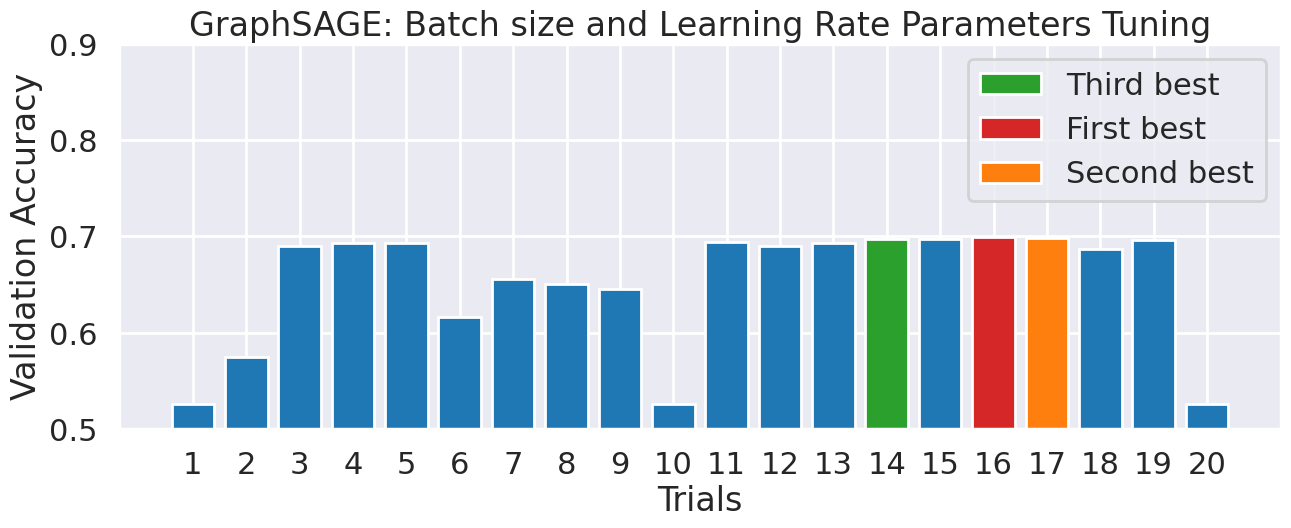

In [14]:
study2_df = study2.trials_dataframe()
study2_df_sort = study2_df.sort_values(by="value", ascending=False).reset_index()
top_three_expts = study2_df_sort["number"].to_numpy()[:3]

fig, ax = plt.subplots(figsize=(15,5))
x_values = [str(i+1) for i in study2_df["number"]]
bar_labels = []
bar_colors = []
for i in range(len(x_values)):
    if i == top_three_expts[0]:
        bar_labels.append("First best")
        bar_colors.append("tab:red")
    elif i == top_three_expts[1]:
        bar_labels.append("Second best")
        bar_colors.append("tab:orange")
    elif i == top_three_expts[2]:
        bar_labels.append("Third best")
        bar_colors.append("tab:green")
    else:
        bar_labels.append("_")
        bar_colors.append("tab:blue")

ax.bar(x_values, study2_df["value"], label=bar_labels, color=bar_colors)
ax.set_xlabel("Trials")
ax.set_ylabel("Validation Accuracy")
ax.set_ylim([0.5, 0.9])
ax.set_title("GraphSAGE: Batch size and Learning Rate Parameters Tuning")
ax.legend()

In [12]:
# Get the top 3 best hyperparameters from Study 2
for i, text in enumerate(["First", "Second", "Third"]):
    acc = study2_df_sort.value.iloc[i]
    if i == 0:
        print(f"\n\nFirst Best (val. acc. = {acc:.5f})")
    elif i == 1:
        print(f"\n\nSecond Best (val. acc. = {acc:.5f})")
    elif i == 2:
        print(f"\n\nThird Best (val. acc. = {acc:.5f})")
    print(f"----------------------------------")
    j = study2_df_sort.number.iloc[i]
    for param_name, param_value in study2.trials[j].params.items():
        if isinstance(param_value, float):
            print(f"{param_name} : {param_value:.3e}")
        else:
            print(f"{param_name} : {param_value}")



First Best (val. acc. = 0.69920)
----------------------------------
batch_size : 202
lr : 1.499e-02
lr_step : 290
lr_gamma : 9.029e-01


Second Best (val. acc. = 0.69869)
----------------------------------
batch_size : 191
lr : 1.902e-02
lr_step : 275
lr_gamma : 9.030e-01


Third Best (val. acc. = 0.69769)
----------------------------------
batch_size : 256
lr : 1.128e-02
lr_step : 356
lr_gamma : 9.020e-01


### Final GraphSAGE Model

From above studies, we have

**Model architecture**:

- num_hidden_layers : 3
- neurons_1 : 32
- neurons_2 :  64
- neurons_3 :  64
- dropout_prob : 1.349e-03

**Training**:

- batch_size : 202- lr : 1.499e-02
- lr_step : 290
- lr_gamma : 9.029e-01